In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

from sklearn.metrics import mutual_info_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler

import pickle 

In [39]:
train_data = pd.read_csv('../../data/processed/training.csv',)
test_data = pd.read_csv('../../data/processed/test.csv', )

In [40]:
df_train, df_val = train_test_split(train_data, test_size=0.2, random_state=15)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.fraudresult.values
y_val = df_val.fraudresult.values

del df_train['fraudresult']
del df_val['fraudresult']

In [41]:
cat_features =  df_train.select_dtypes(include=['object']).columns.to_list()

cat_features = [i for i in cat_features if i not in ['transactionid', 'batchid', 'accountid', 'subscriptionid', 
    'customerid', 'currencycode']]
cat_features

['providerid', 'productid', 'productcategory', 'channelid']

In [42]:
num_features = df_train.select_dtypes(exclude=['object', 'datetime64']).columns.to_list()
num_features = [i for i in num_features if i not in ['transactionstarttime_dom', 
    'transactionstarttime_doy', 'transactionstarttime_min', 'transactionstarttime_wkoyr']]

num_features

['countrycode',
 'amount',
 'value',
 'pricingstrategy',
 'transactionstarttime_dow',
 'transactionstarttime_hr',
 'transactionstarttime_is_wkd',
 'transactionstarttime_mth',
 'transactionstarttime_qtr',
 'transactionstarttime_yr']

In [43]:
cat = df_train[cat_features + num_features].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(cat)

X = dv.transform(cat)

In [45]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.998275 (0.000330)
LDA: 0.998210 (0.000475)
KNN: 0.999412 (0.000168)
CART: 0.999334 (0.000136)
RF: 0.999360 (0.000251)
NB: 0.996263 (0.000543)
SVM: 0.999490 (0.000148)


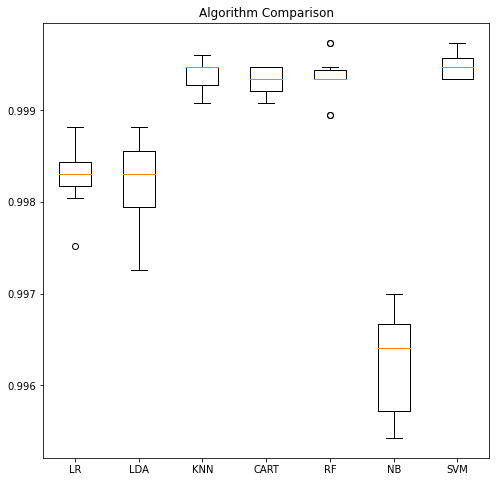

In [46]:
plt.figure(figsize=(8,8))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [16]:
val_dict = df_val[cat_features + num_features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [19]:
# Make predictions on validation dataset
model = DecisionTreeClassifier()
model.fit(X, y_train)
predictions = model.predict(X_val)

In [20]:
print(accuracy_score(y_val, predictions))
print(confusion_matrix(y_val, predictions))
print(classification_report(y_val, predictions))

0.9995565269726631
[[31501     5]
 [    9    54]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31506
           1       0.92      0.86      0.89        63

    accuracy                           1.00     31569
   macro avg       0.96      0.93      0.94     31569
weighted avg       1.00      1.00      1.00     31569



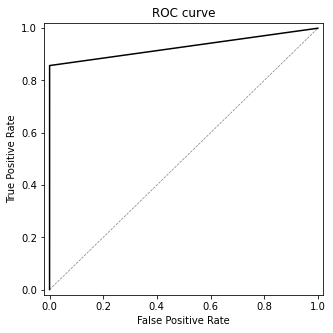

In [21]:
fpr, tpr, thresholds = roc_curve(y_val, predictions)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

In [22]:
auc(fpr, tpr)

0.9284920786063426

In [23]:
roc_auc_score(y_val, predictions)

0.9284920786063426

In [32]:
def train(df, y, max_depth = 10):
    cat = df[cat_features + num_features].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[cat_features + num_features].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [33]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [34]:
aucs = []

for train_idx, val_idx in kfold.split(train_data):
    df_train = train_data.iloc[train_idx]
    y_train = df_train.fraudresult.values

    df_val = train_data.iloc[val_idx]
    y_val = df_val.fraudresult.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

np.array(aucs).round(3)

array([0.928, 0.972, 0.972, 1.   , 0.972, 0.944, 0.966, 0.937, 0.912,
       0.907])

## Random under-sampling with imblearn

In [1]:
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(X, y_train)

svc_predict = svc_model.predict(X_val)


NameError: name 'SVC' is not defined

In [ ]:
# import library


rus = RandomUnderSampler(random_state=42, replacement=True)

# fit predictor and target varialbe
x_rus, y_rus = rus.fit_resample(x, y)

print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_rus))


In [35]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.951 ± 0.029


In [36]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for max_depth in [5, 10, 15, 30, 50, 70]:
    aucs = []

    for train_idx, val_idx in kfold.split(train_data):
        df_train = train_data.iloc[train_idx]
        df_val = train_data.iloc[val_idx]

        y_train = df_train.fraudresult.values
        y_val = df_val.fraudresult.values

        dv, model = train(df_train, y_train, max_depth=max_depth)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('max_depth=%s, auc = %0.3f ± %0.3f' % (max_depth, np.mean(aucs), np.std(aucs)))

max_depth=5, auc = 0.974 ± 0.040
max_depth=10, auc = 0.956 ± 0.022
max_depth=15, auc = 0.947 ± 0.023
max_depth=30, auc = 0.947 ± 0.023
max_depth=50, auc = 0.947 ± 0.023
max_depth=70, auc = 0.947 ± 0.023


In [37]:
y_train = train_data.fraudresult.values
y_test = test_data.fraudresult.values

dv, model = train(train_data, y_train, max_depth = 5)
y_pred = predict(test_data, dv, model)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

AttributeError: 'DataFrame' object has no attribute 'fraudresult'